In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm
import scipy
import re
Path = '/home/icb/manuel.gander/Atl/data'

In [37]:
dfd = pd.read_pickle(f'{Path}/Synched_aucs.pkl')
dfd = dfd.drop_duplicates(['PubChem_CID', 'Dr_repr_name']).copy()
D_dr_rep = dict(zip(dfd['PubChem_CID'], dfd['Dr_repr_name']))

In [38]:
D_s_m = {'GDSC1':'GDSC_v1', 'GDSC2':'GDSC_v2', 'CTD2':'CTRP_v2', 'CTPR':'CTRP_v1', 'MR_NCI60':'NCI_60', 'PRISM2':'PRISM2', 'DTP':'DTP'}

In [39]:
datasets = ['atlantic', 'atl_only_phos', 'atl_only_full', 'Gygi', 'kinase_scores', 'RNA', 'drug_scores', 'atl_full_and_kinases', 'identity']

In [40]:
mypath=f'{Path}/dones_grid'
keys=listdir(mypath)
if '.ipynb_checkpoints' in keys:
    keys.remove('.ipynb_checkpoints')
len(keys)

2352

In [41]:
# Check if there are keys missing
def remove_non_alphanumeric(input_string):
    # Muster für alle alphanumerischen Zeichen und Leerzeichen
    pattern = re.compile(r'[^a-zA-Z0-9 ]+')
    # Ersetze alle nicht-alphanumerischen Zeichen mit einem leeren String
    result = pattern.sub('', input_string)
    return result

In [42]:
dfd = pd.read_csv(f'{Path}/drugs_annotated.txt', sep='\t')
dfd['Drug'] = [a[:-1] for a in dfd['Drug']]
dfd.index=range(len(dfd))
dfd['dr'] = [remove_non_alphanumeric(a).lower() for a in dfd['Drug']]
dfd

,Drug,Target,MOA,Kinase target,dr
0,123138,x,x,x,123138
1,123829,x,x,x,123829
2,150412,x,x,x,150412
3,5-Fluorouracil,x,Nucelosid analog,x,5fluorouracil
4,5-azacytidine,x,Nucelosid analog,x,5azacytidine
...,...,...,...,...,...
283,ZM447439,"Aurka, Aurkb, Aurkc",Checkpoint signaling,y,zm447439
284,Zoledronate,x,DNA repair,x,zoledronate
285,alpha-lipoic acid,x,Metabolism,x,alphalipoic acid
286,ascorbate (vitamin C),x,Metabolism,x,ascorbate vitamin c


In [43]:
dfv=pd.read_pickle(f"{Path}/Synched_aucs.pkl")
dfv['dr'] = [remove_non_alphanumeric(a).lower() for a in dfv['Dr_repr_name']]
dfv = dfv[dfv['dr'].isin(list(dfd['dr']))]

In [44]:
sources=['CTD2', 'GDSC1', 'GDSC2', 'DTP', 'CTPR', 'MR_NCI60']

In [45]:
for s in sources:
    dfvs = dfv[dfv['Source']==s].copy()
    print(s)
    print(len(set(dfvs['PubChem_CID'])))
    print('-------')

CTD2
80
-------
GDSC1
112
-------
GDSC2
227
-------
DTP
140
-------
CTPR
32
-------
MR_NCI60
41
-------


In [46]:
datasets = ['atlantic', 'atl_only_phos', 'atl_only_full', 'Gygi', 'kinase_scores', 'RNA', 'drug_scores', 'identity']

sources=['CTD2', 'GDSC1', 'GDSC2', 'DTP', 'CTPR', 'MR_NCI60']


alphas = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0]
l1_ratios = [0.01, 0.03, 0.1, 0.3, 0.5, 0.9, 0.99]

In [47]:
keys2 = []
for dataset in datasets:
    for source in sources:
        for alpha in alphas:
            for l1_ratio in l1_ratios:
                keys2.append(f'{alpha}_{l1_ratio}_{dataset}_{source}.pkl')

In [48]:
len(keys2)

2352

In [49]:
frames = []
for k in tqdm(keys):
    df = pd.read_pickle(mypath+'/'+k)
    frames.append(df.groupby(['PubChem_CID', 'alpha', 'l1_ratio', 'dataset', 'source']).mean().reset_index())
Df = pd.concat(frames, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2352/2352 [02:02<00:00, 19.24it/s]


In [50]:
#df = Df.groupby(['PubChem_CID', 'alpha', 'l1_ratio', 'dataset', 'source']).mean().reset_index()
df = Df.copy()
df = df[np.isfinite(df['pearsons'])]
df['drug_repr'] = df['PubChem_CID'].map(D_dr_rep)
df['RMSE_ratio'] = df['RMSE']/df['RMSE_mean_model']
df.sort_values('pearsons')

,PubChem_CID,alpha,l1_ratio,dataset,source,pearsons,spearmans,l1_ratios,RMSE,RMSE_mean_model,ind,n_ccls,kn,drug_repr,RMSE_ratio
663037,400501,1.00,0.10,Gygi,DTP,-0.974465,-1.000000,1.000112,0.112559,0.112539,49.5,33.0,1.000000e+09,Ambewelamide A,1.000178
45614,400501,10.00,0.01,Gygi,DTP,-0.974465,-1.000000,1.000022,0.112543,0.112539,49.5,33.0,1.000000e+09,Ambewelamide A,1.000035
45165,20055431,10.00,0.01,Gygi,DTP,-0.965357,-0.942857,1.000021,0.102523,0.102523,49.5,34.0,1.000000e+09,Actinomycin C3,1.000007
282505,20055431,0.10,0.99,Gygi,DTP,-0.965357,-0.942857,1.000245,0.102531,0.102523,49.5,34.0,1.000000e+09,Actinomycin C3,1.000080
662588,20055431,1.00,0.10,Gygi,DTP,-0.965357,-0.942857,1.000096,0.102526,0.102523,49.5,34.0,1.000000e+09,Actinomycin C3,1.000031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372192,5459116,0.30,0.10,identity,DTP,0.984208,0.629749,0.926855,0.190724,0.203439,49.5,39.0,1.000000e+09,Claenone,0.937501
48750,5459116,3.00,0.01,identity,DTP,0.984208,0.629749,0.990884,0.201847,0.203439,49.5,39.0,1.000000e+09,Claenone,0.992175
601723,5459116,1.00,0.03,identity,DTP,0.984208,0.629749,0.974074,0.198917,0.203439,49.5,39.0,1.000000e+09,Claenone,0.977772
73473,5459116,0.03,0.99,identity,DTP,0.984208,0.629749,0.751976,0.160817,0.203439,49.5,39.0,1.000000e+09,Claenone,0.790492


<Axes: xlabel='RMSE_ratio', ylabel='pearsons'>

/home/icb/manuel.gander/ott_env/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/icb/manuel.gander/ott_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


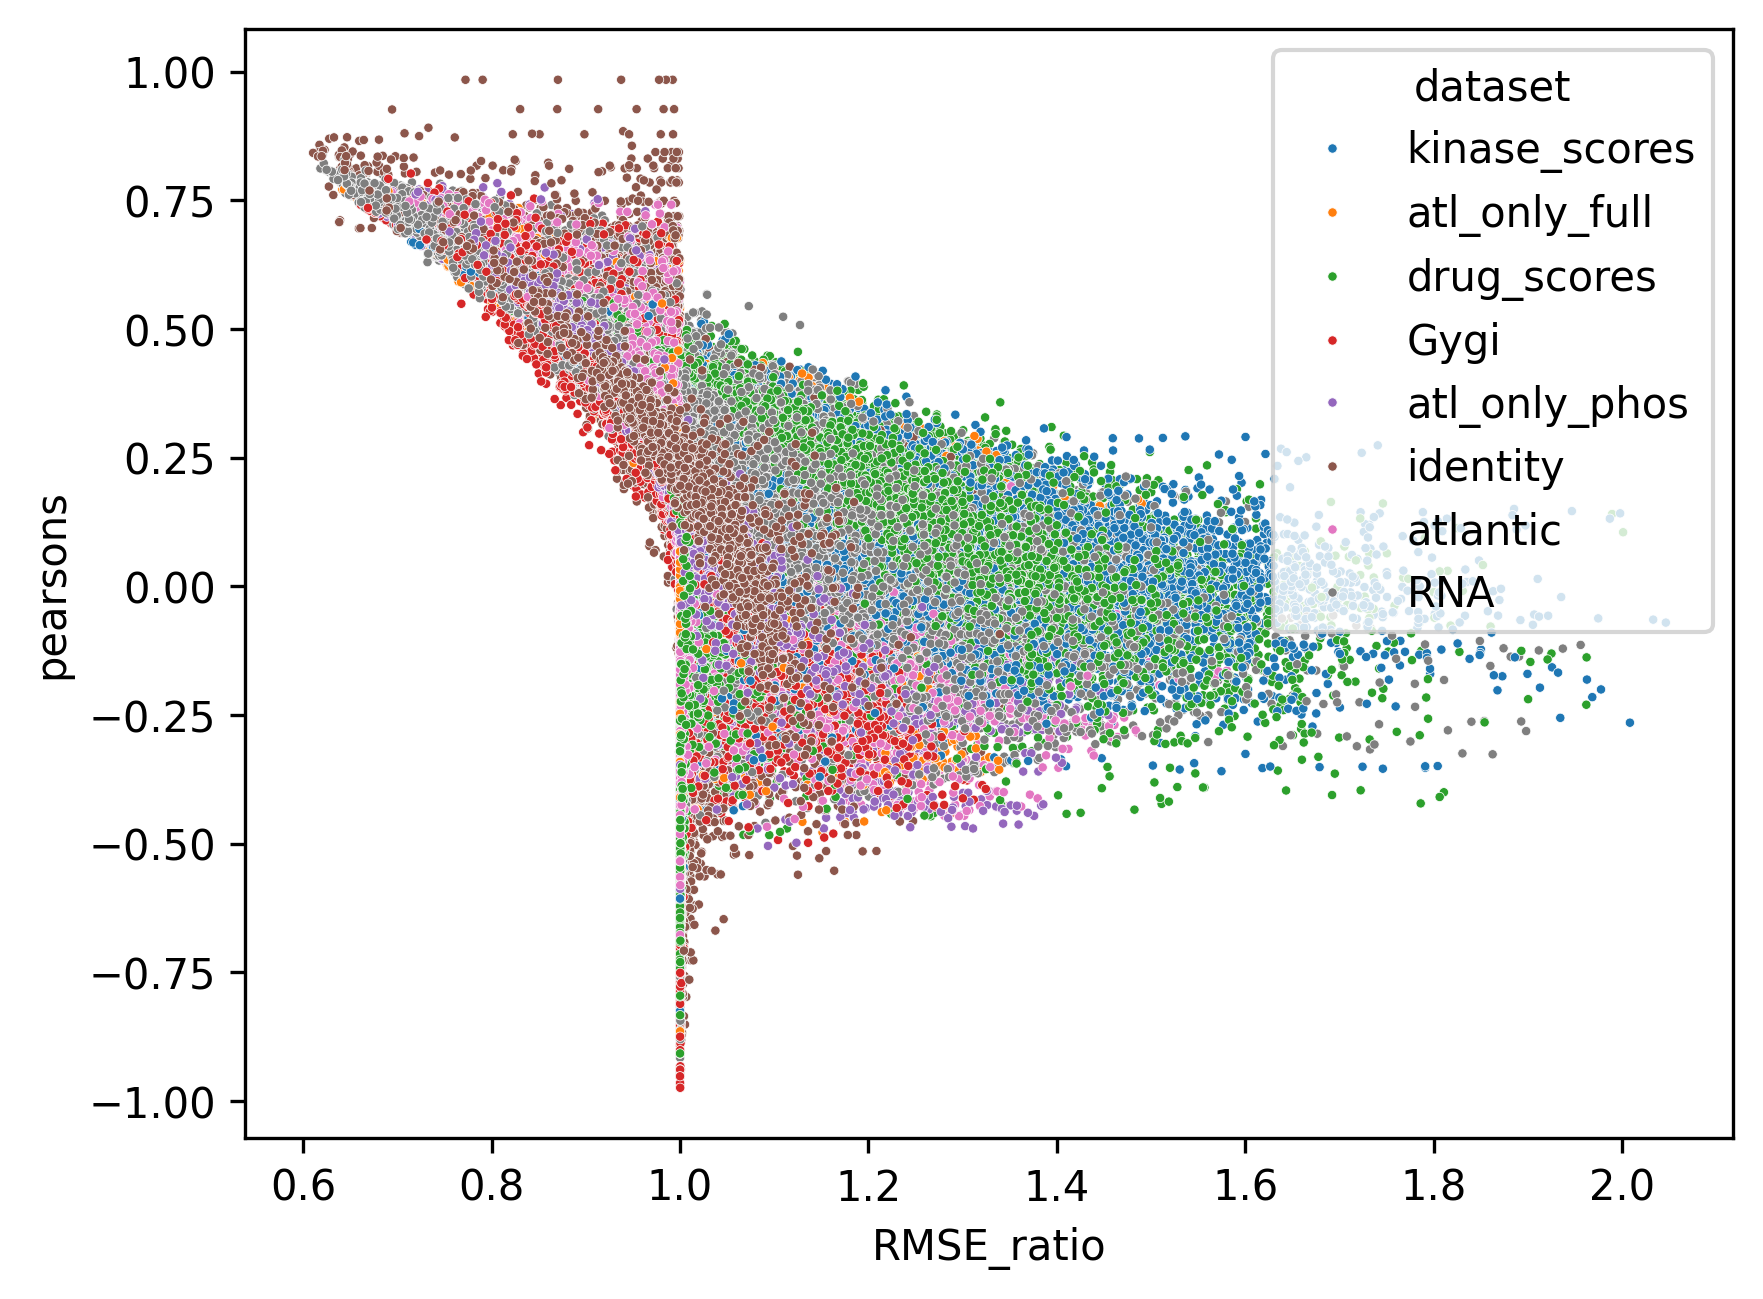

In [51]:
sns.scatterplot(data=df, x='RMSE_ratio', y='pearsons', s=5, hue='dataset')

<Axes: xlabel='RMSE_ratio', ylabel='pearsons'>

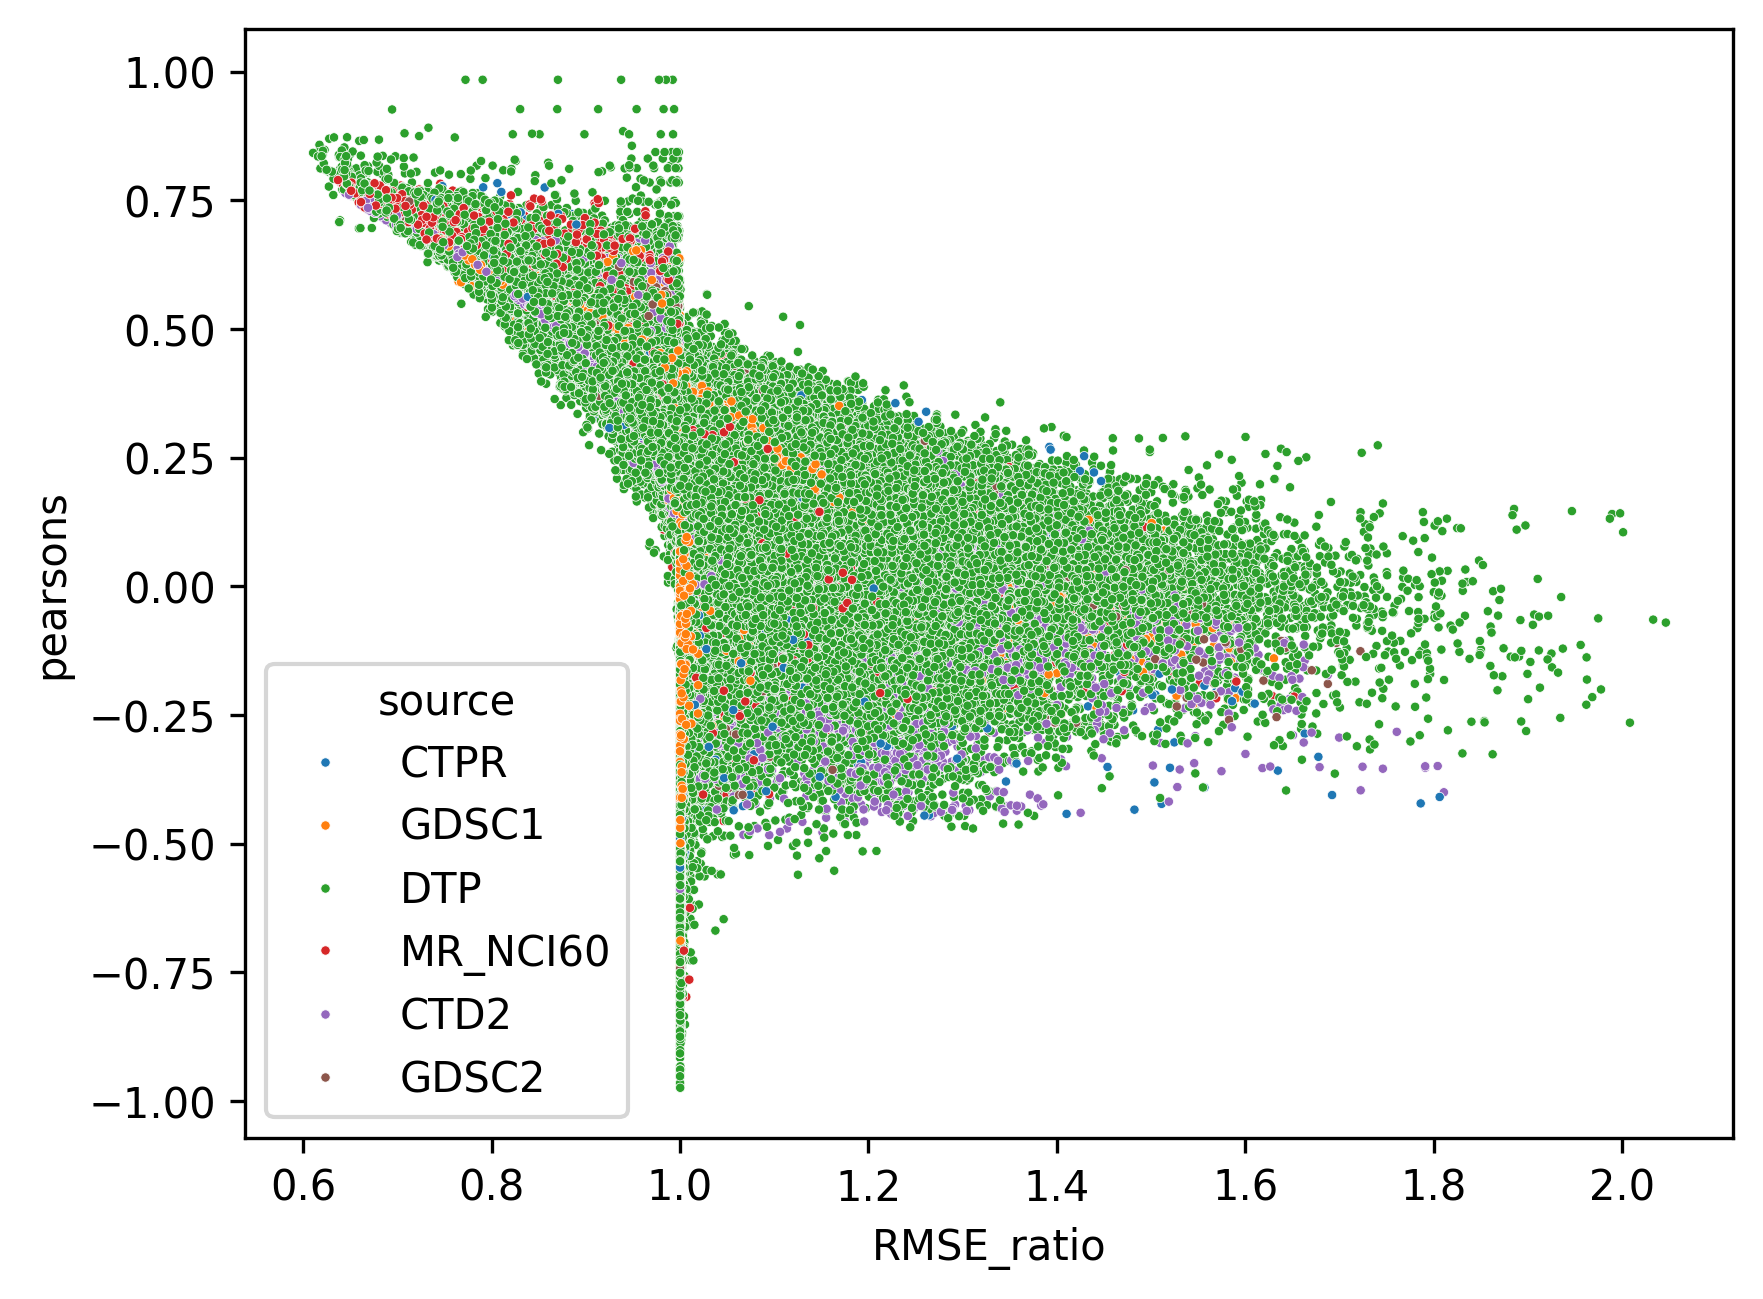

In [52]:
sns.scatterplot(data=df, x='RMSE_ratio', y='pearsons', s=5, hue='source')

In [53]:
# Pick the one with the best l1_ratio and alpha
crit = 'RMSE_ratio'
crit = 'pearsons'

alphas = sorted(set(df['alpha']))
l1_ratios = sorted(set(df['l1_ratio']))
datas = sorted(set(df['dataset']))
sources = sorted(set(df['source']))


frames = []
for source in sources:
    for data in datas:
        dfs = df[(df['source']==source)&(df['dataset']==data)].copy()
        drugs = sorted(set(dfs['PubChem_CID']))
        for d in drugs:
            dfss = dfs[dfs['PubChem_CID']==d].copy()
            if crit=='RMSE_ratio':
                frames.append(dfss.sort_values(crit).iloc[:1])
            else:
                frames.append(dfss.sort_values(crit).iloc[-1:])
dfm = pd.concat(frames, ignore_index=True)
dfm.sort_values('pearsons')

,PubChem_CID,alpha,l1_ratio,dataset,source,pearsons,spearmans,l1_ratios,RMSE,RMSE_mean_model,ind,n_ccls,kn,drug_repr,RMSE_ratio
10234,3372016,0.01,0.30,identity,DTP,-0.484621,-0.413188,1.049912,0.080117,0.076052,49.5,39.0,1.000000e+09,BPTES,1.053452
10236,3379405,0.01,0.30,identity,DTP,-0.426737,-0.383191,1.059317,0.092820,0.086374,49.5,39.0,1.000000e+09,guaneran,1.074635
10378,384456,0.01,0.01,identity,DTP,-0.426605,-0.362566,1.142655,0.076848,0.065823,49.5,38.0,1.000000e+09,2-(2-Acetylbenzimidazol-1-yl)-1-(4-methoxyphen...,1.167495
10856,6442177,0.01,0.30,identity,DTP,-0.421005,-0.433311,1.090052,0.111619,0.101968,49.5,39.0,1.000000e+09,everolimus,1.094651
6251,354399,0.10,0.50,atl_only_phos,DTP,-0.392281,-0.368626,1.069819,0.133415,0.126802,49.5,62.0,1.000000e+09,from marine animal dolabella auricularia,1.052154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10926,71727581,0.01,0.50,identity,DTP,0.843700,0.726899,0.616231,0.082057,0.133059,49.5,39.0,1.000000e+09,GDC-0994,0.616697
10998,90116675,0.03,0.90,identity,DTP,0.855977,0.596040,0.915519,0.139356,0.146866,49.5,40.0,1.000000e+09,PLX-8394,0.948868
9999,168314623,1.00,0.03,identity,DTP,0.878278,0.660584,0.972739,0.141803,0.144766,49.5,39.0,1.000000e+09,SB-590885-AAD,0.979529
9965,155813556,1.00,0.03,identity,DTP,0.927088,0.669992,0.977786,0.110854,0.112823,49.5,39.0,1.000000e+09,ARQ-680,0.982550


In [54]:
# Print the correlations for each dataset for 

In [55]:
dfm['dr'] = [remove_non_alphanumeric(a).lower() for a in dfm['drug_repr']]

In [56]:
dfms = dfm[dfm['dr'].isin(list(dfd['dr']))].copy()

In [57]:
Dr_to_kin=dict(zip(dfd['dr'], dfd['Kinase target']))

In [58]:
dfms['kinase_target'] = dfms['dr'].map(Dr_to_kin)

In [59]:
dss = sorted(set(dfms['dataset']))

In [60]:
dfms['Kinase_Inhibitor'] = [True if a=='y' else False for a in dfms['kinase_target']]

In [62]:
dfms

,PubChem_CID,alpha,l1_ratio,dataset,source,pearsons,spearmans,l1_ratios,RMSE,RMSE_mean_model,ind,n_ccls,kn,drug_repr,RMSE_ratio,dr,kinase_target,Kinase_Inhibitor
1,10127622,1.00,0.01,Gygi,CTD2,0.505040,0.510447,0.812510,0.146325,0.168719,49.5,336.0,1.000000e+09,selumetinib,0.867270,selumetinib,y,True
2,10184653,3.00,0.01,Gygi,CTD2,0.386775,0.351559,0.941297,0.138974,0.145683,49.5,307.0,1.000000e+09,afatinib,0.953946,afatinib,y,True
6,104842,1.00,0.01,Gygi,CTD2,0.503674,0.444945,0.852495,0.122898,0.141430,49.5,288.0,1.000000e+09,SN-38,0.868967,sn38,x,False
11,11228183,3.00,0.01,Gygi,CTD2,0.512556,0.211786,0.925067,0.126807,0.140220,49.5,318.0,1.000000e+09,ABT737,0.904338,abt737,x,False
14,11364421,1.00,0.01,Gygi,CTD2,0.616718,0.616635,0.765314,0.158598,0.201152,49.5,342.0,1.000000e+09,BI-2536,0.788448,bi2536,y,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,51001932,0.03,0.90,kinase_scores,MR_NCI60,0.306142,0.252807,0.951892,0.130842,0.136284,49.5,61.0,1.000000e+09,taselisib,0.960070,taselisib,y,True
14140,51042438,3.00,0.01,kinase_scores,MR_NCI60,0.280414,0.307331,0.977115,0.129291,0.131433,49.5,61.0,1.000000e+09,uprosertib,0.983702,uprosertib,y,True
14141,5494449,1.00,0.01,kinase_scores,MR_NCI60,0.365767,0.345647,0.956782,0.091521,0.096991,49.5,62.0,1.000000e+09,tozasertib,0.943605,tozasertib,y,True
14147,86287409,0.01,0.10,kinase_scores,MR_NCI60,-0.077793,-0.054518,1.523378,0.100939,0.070336,49.5,61.0,1.000000e+09,temsirolimus,1.435109,temsirolimus,y,True


In [63]:
dfms[dfms['dataset']=='kinase_scores']

,PubChem_CID,alpha,l1_ratio,dataset,source,pearsons,spearmans,l1_ratios,RMSE,RMSE_mean_model,ind,n_ccls,kn,drug_repr,RMSE_ratio,dr,kinase_target,Kinase_Inhibitor
1458,10127622,3.00,0.01,kinase_scores,CTD2,0.489110,0.401170,0.903749,0.167563,0.185328,49.5,70.0,1.000000e+09,selumetinib,0.904139,selumetinib,y,True
1459,10184653,3.00,0.01,kinase_scores,CTD2,0.398221,0.340491,0.961372,0.123593,0.128003,49.5,65.0,1.000000e+09,afatinib,0.965546,afatinib,y,True
1463,104842,0.03,0.50,kinase_scores,CTD2,0.303111,0.290570,0.963934,0.123997,0.129033,49.5,63.0,1.000000e+09,SN-38,0.960973,sn38,x,False
1468,11228183,0.10,0.01,kinase_scores,CTD2,0.028494,0.027457,1.266125,0.123446,0.099174,49.5,69.0,1.000000e+09,ABT737,1.244735,abt737,x,False
1471,11364421,0.10,0.01,kinase_scores,CTD2,0.367587,0.343459,0.970327,0.204211,0.207174,49.5,69.0,1.000000e+09,BI-2536,0.985697,bi2536,y,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,51001932,0.03,0.90,kinase_scores,MR_NCI60,0.306142,0.252807,0.951892,0.130842,0.136284,49.5,61.0,1.000000e+09,taselisib,0.960070,taselisib,y,True
14140,51042438,3.00,0.01,kinase_scores,MR_NCI60,0.280414,0.307331,0.977115,0.129291,0.131433,49.5,61.0,1.000000e+09,uprosertib,0.983702,uprosertib,y,True
14141,5494449,1.00,0.01,kinase_scores,MR_NCI60,0.365767,0.345647,0.956782,0.091521,0.096991,49.5,62.0,1.000000e+09,tozasertib,0.943605,tozasertib,y,True
14147,86287409,0.01,0.10,kinase_scores,MR_NCI60,-0.077793,-0.054518,1.523378,0.100939,0.070336,49.5,61.0,1.000000e+09,temsirolimus,1.435109,temsirolimus,y,True


Gygi
GDSC2
27
30


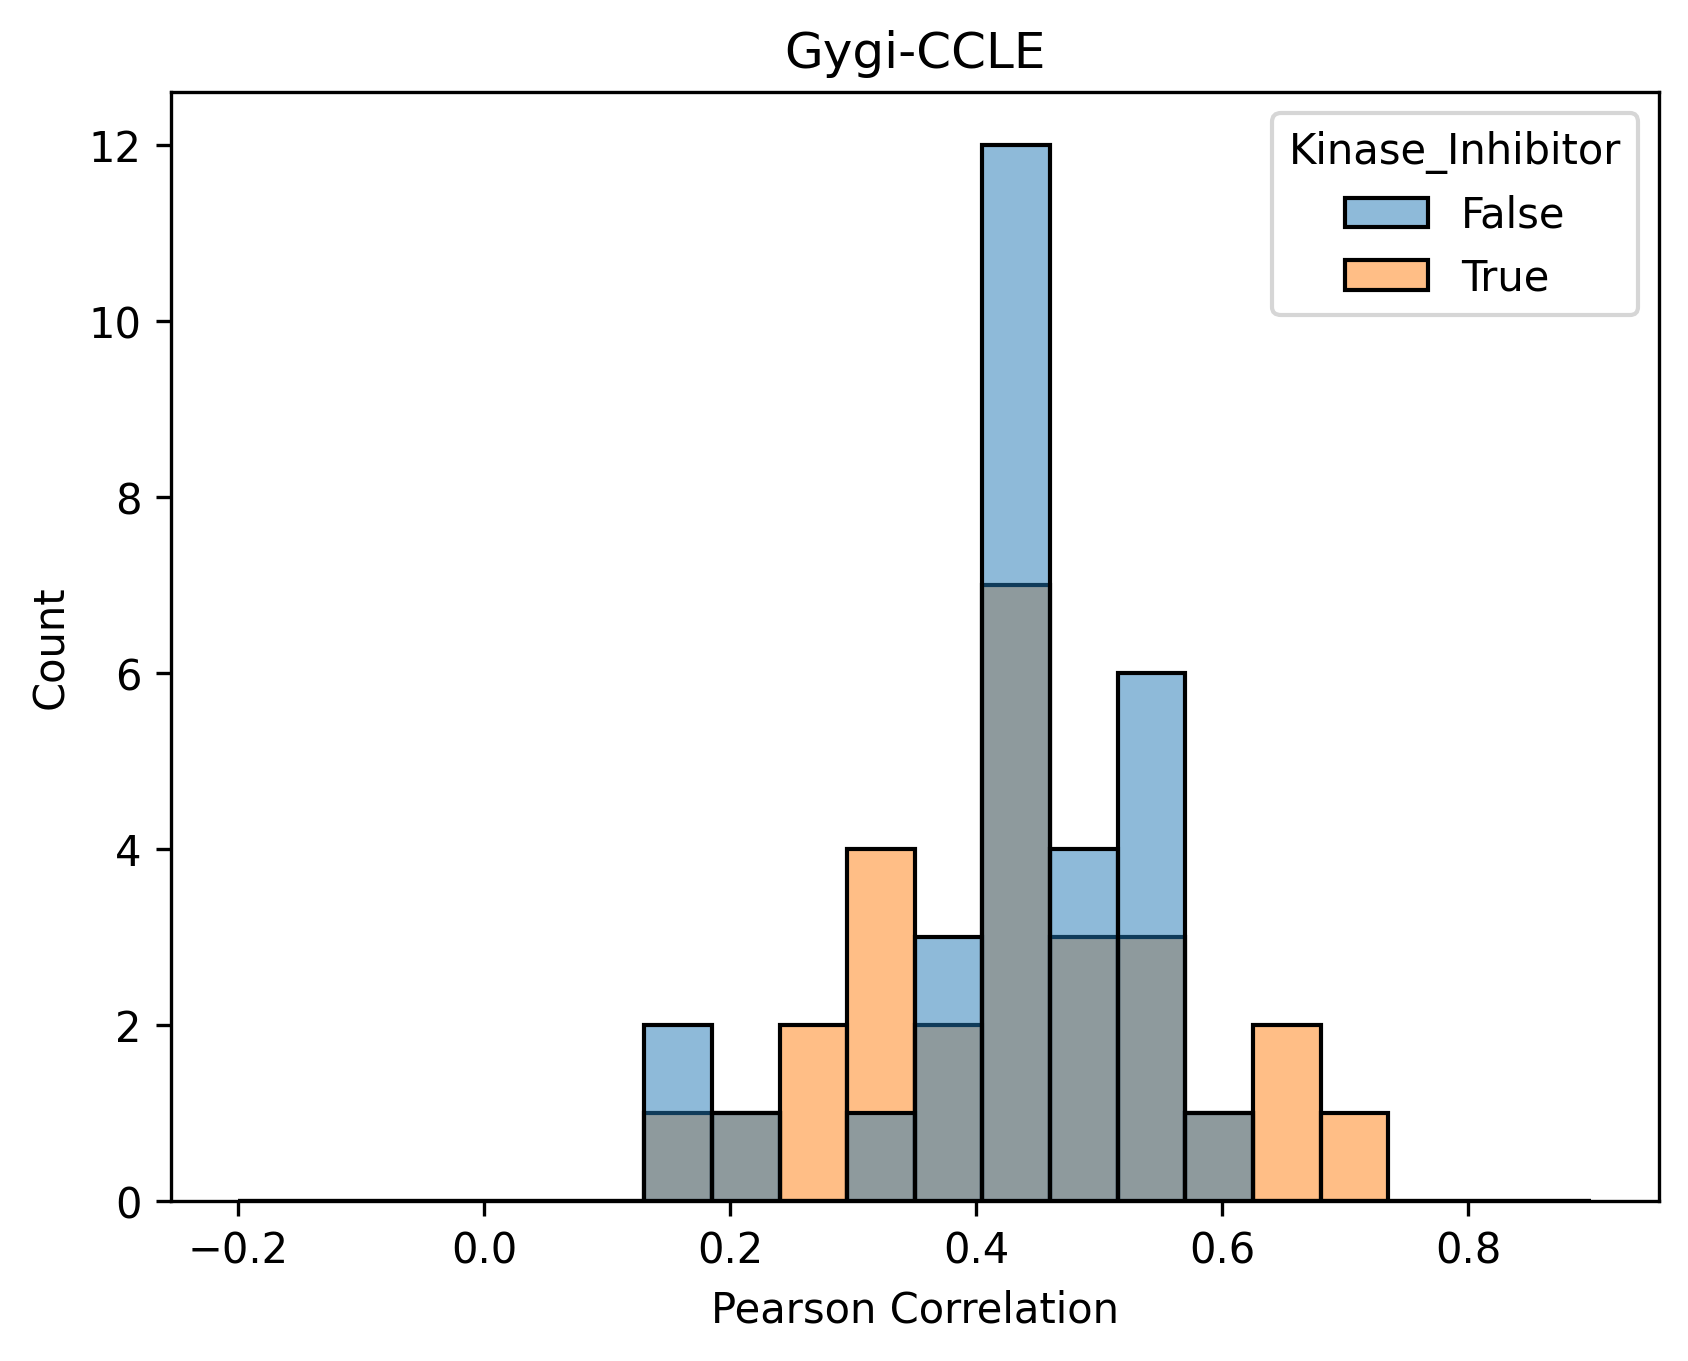

0.9464113654841495
RNA
GDSC2
27
30


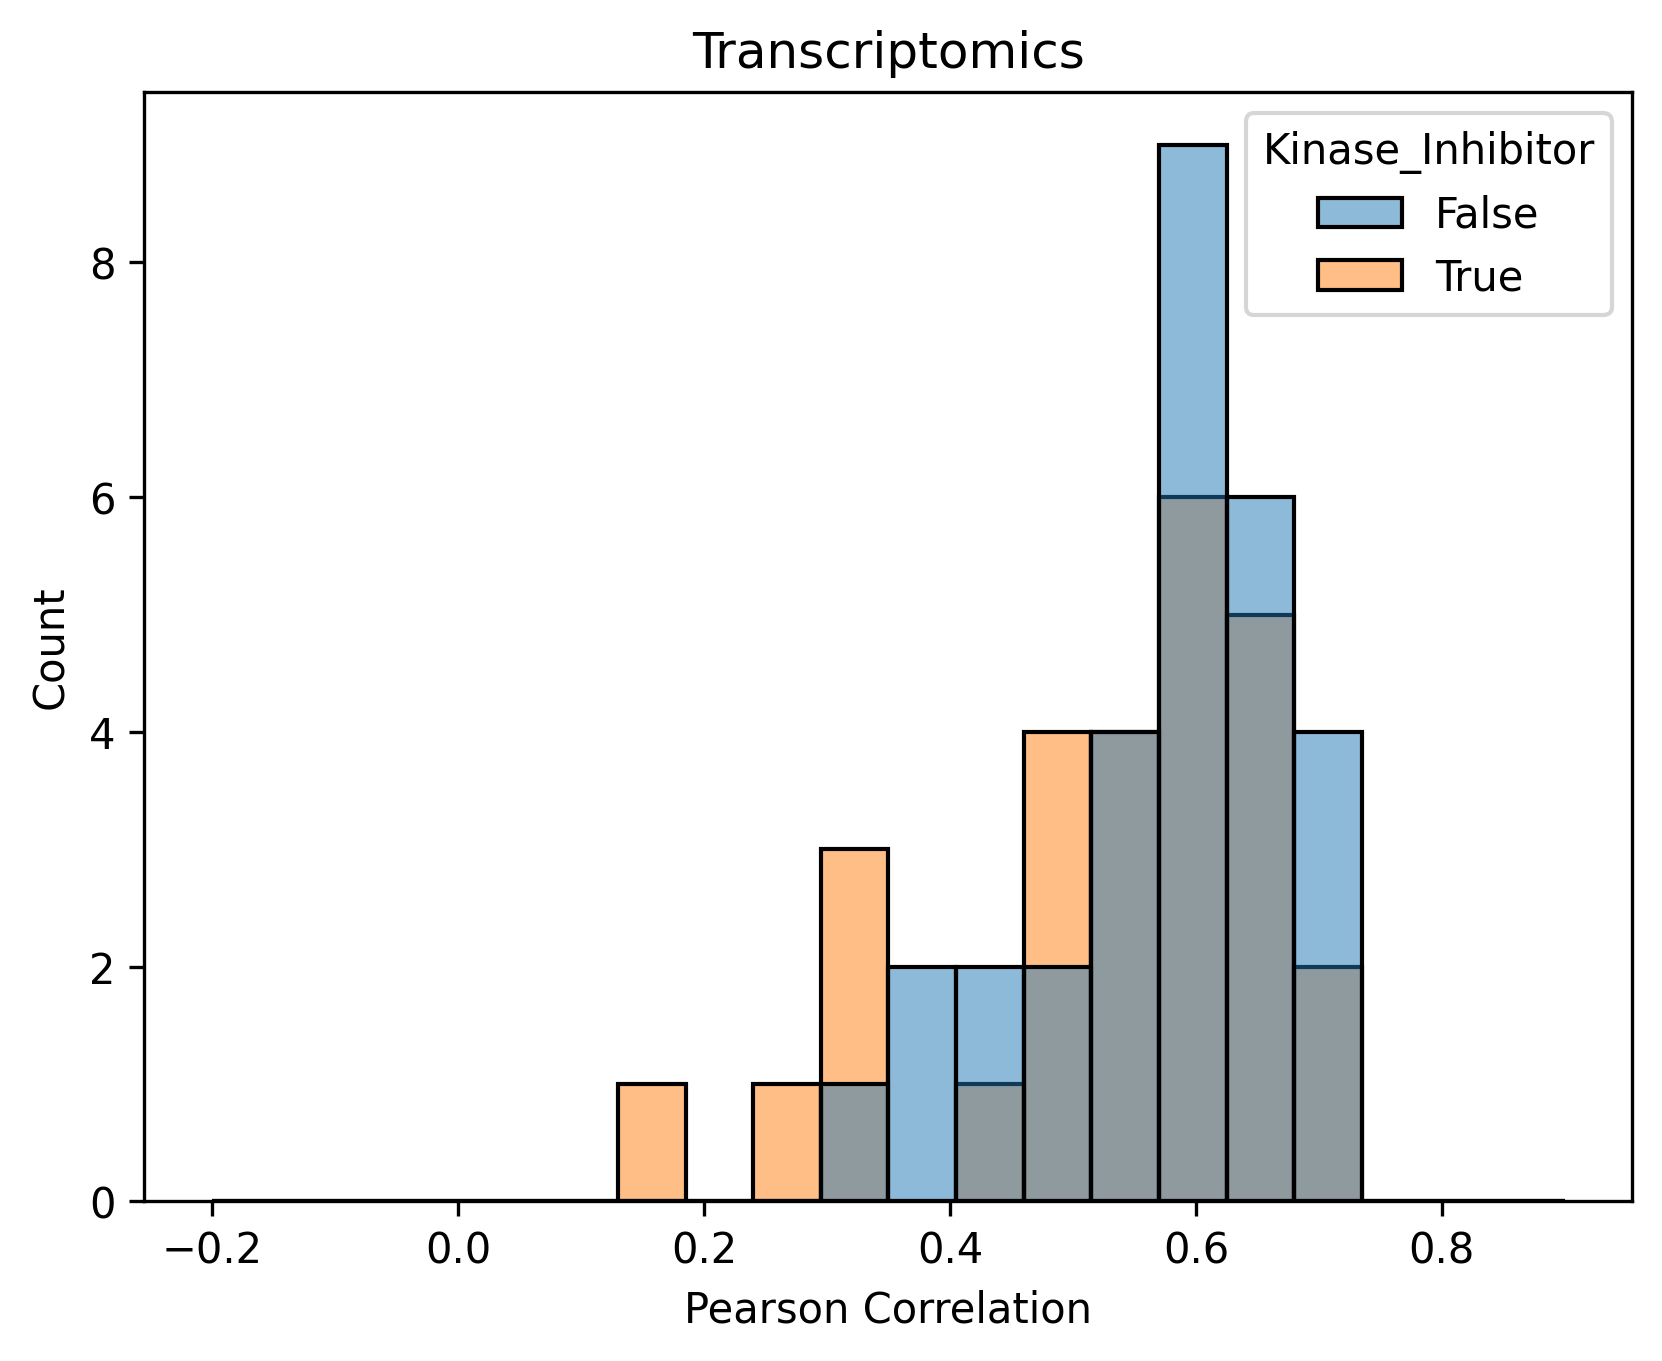

0.11828681437854305
atl_only_full
GDSC2
27
30


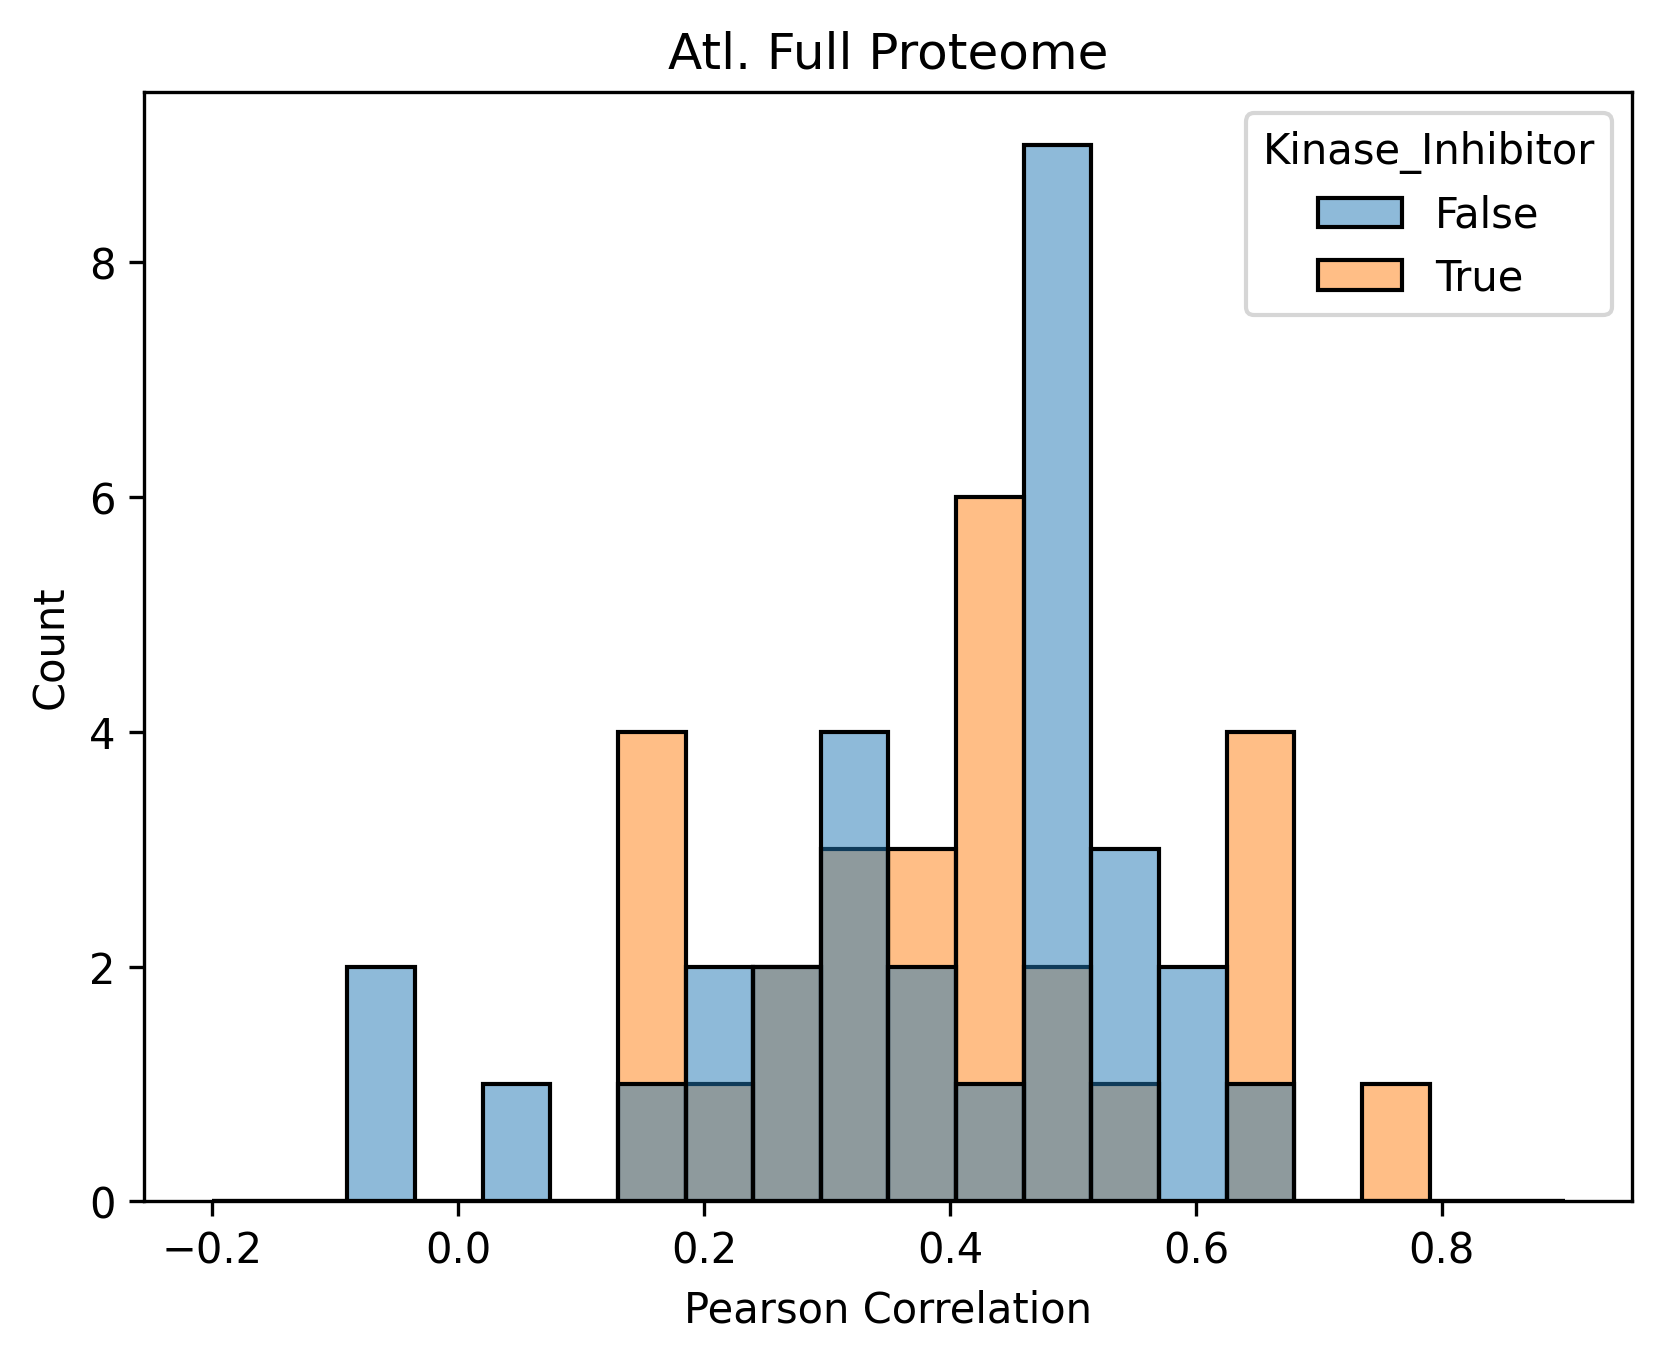

0.544756177134468
atl_only_phos
GDSC2
27
30


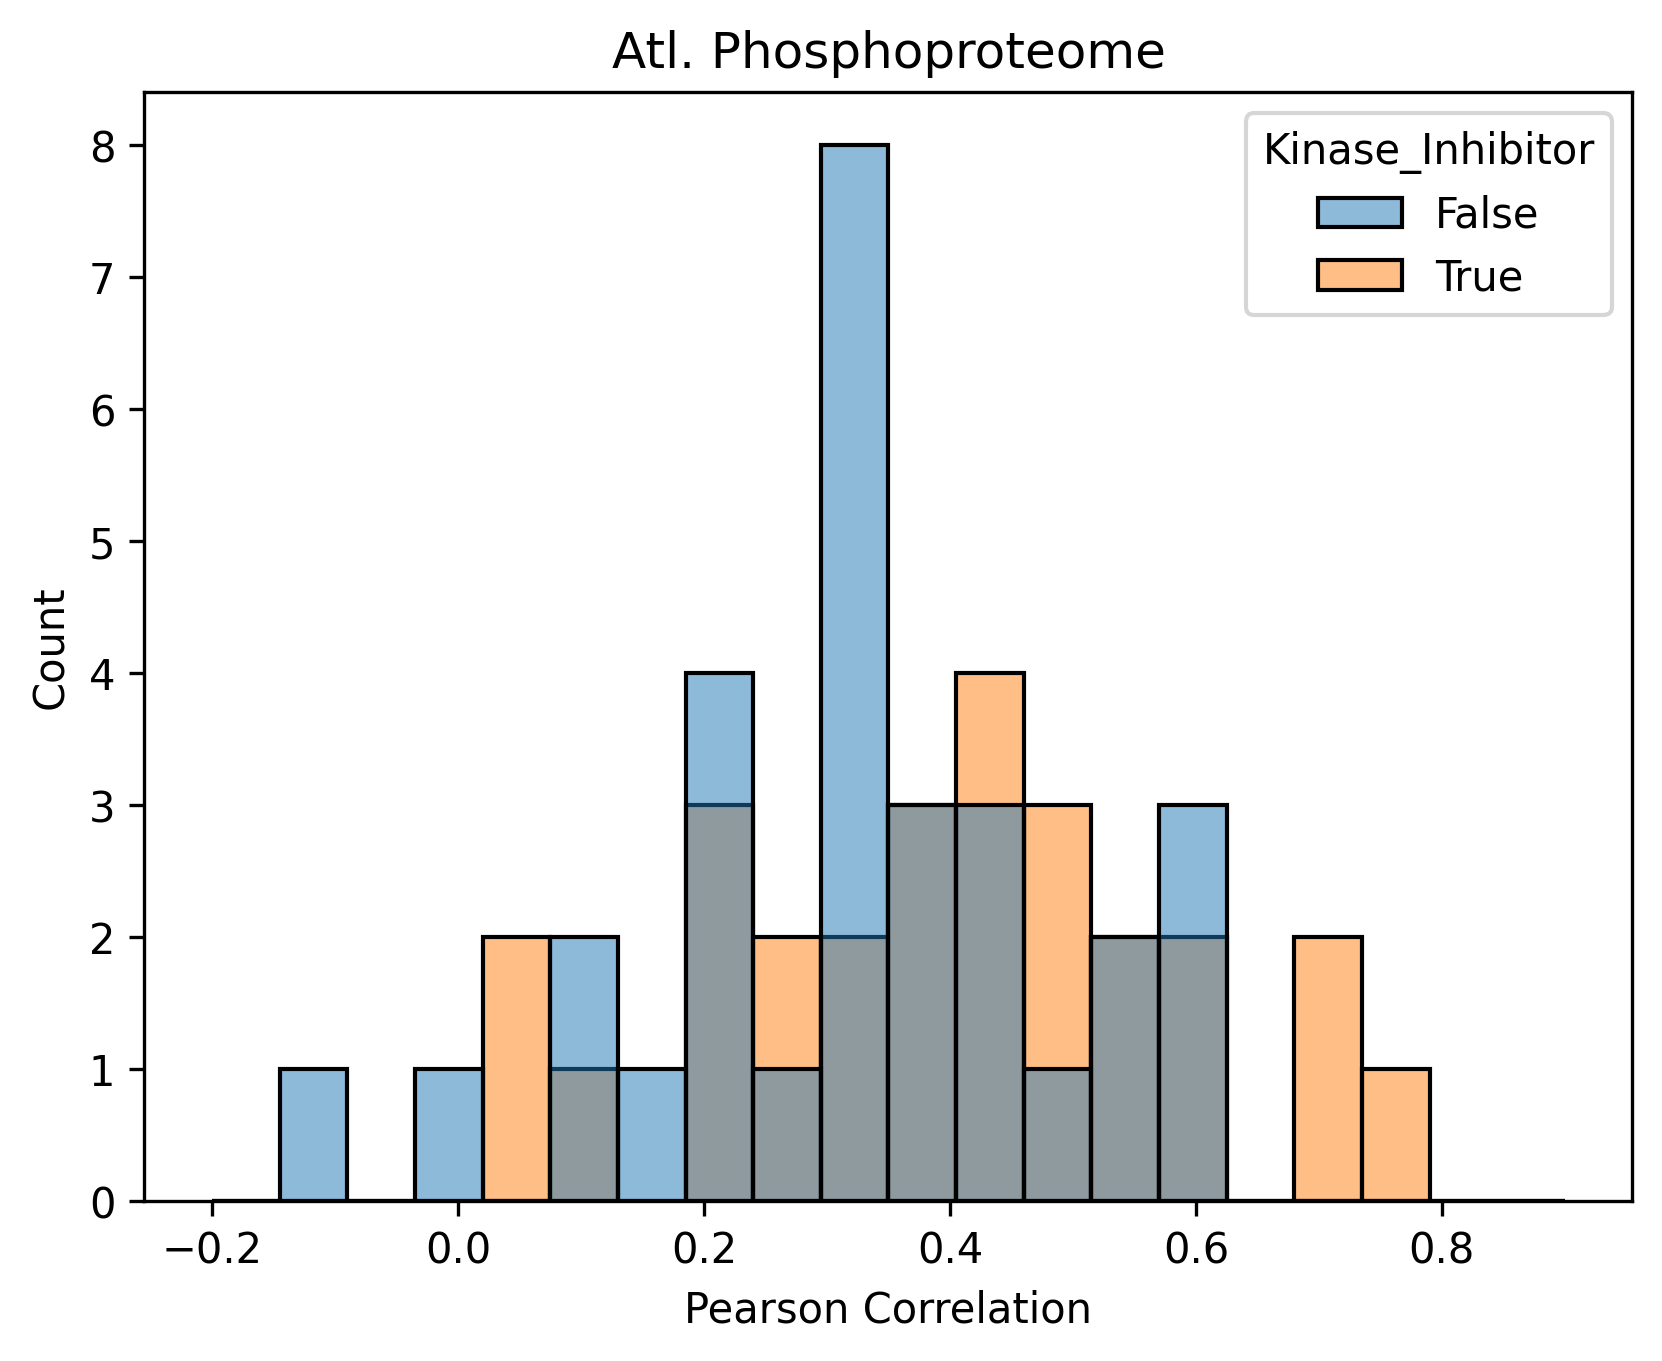

0.15211856346824856
atlantic
GDSC2
27
30


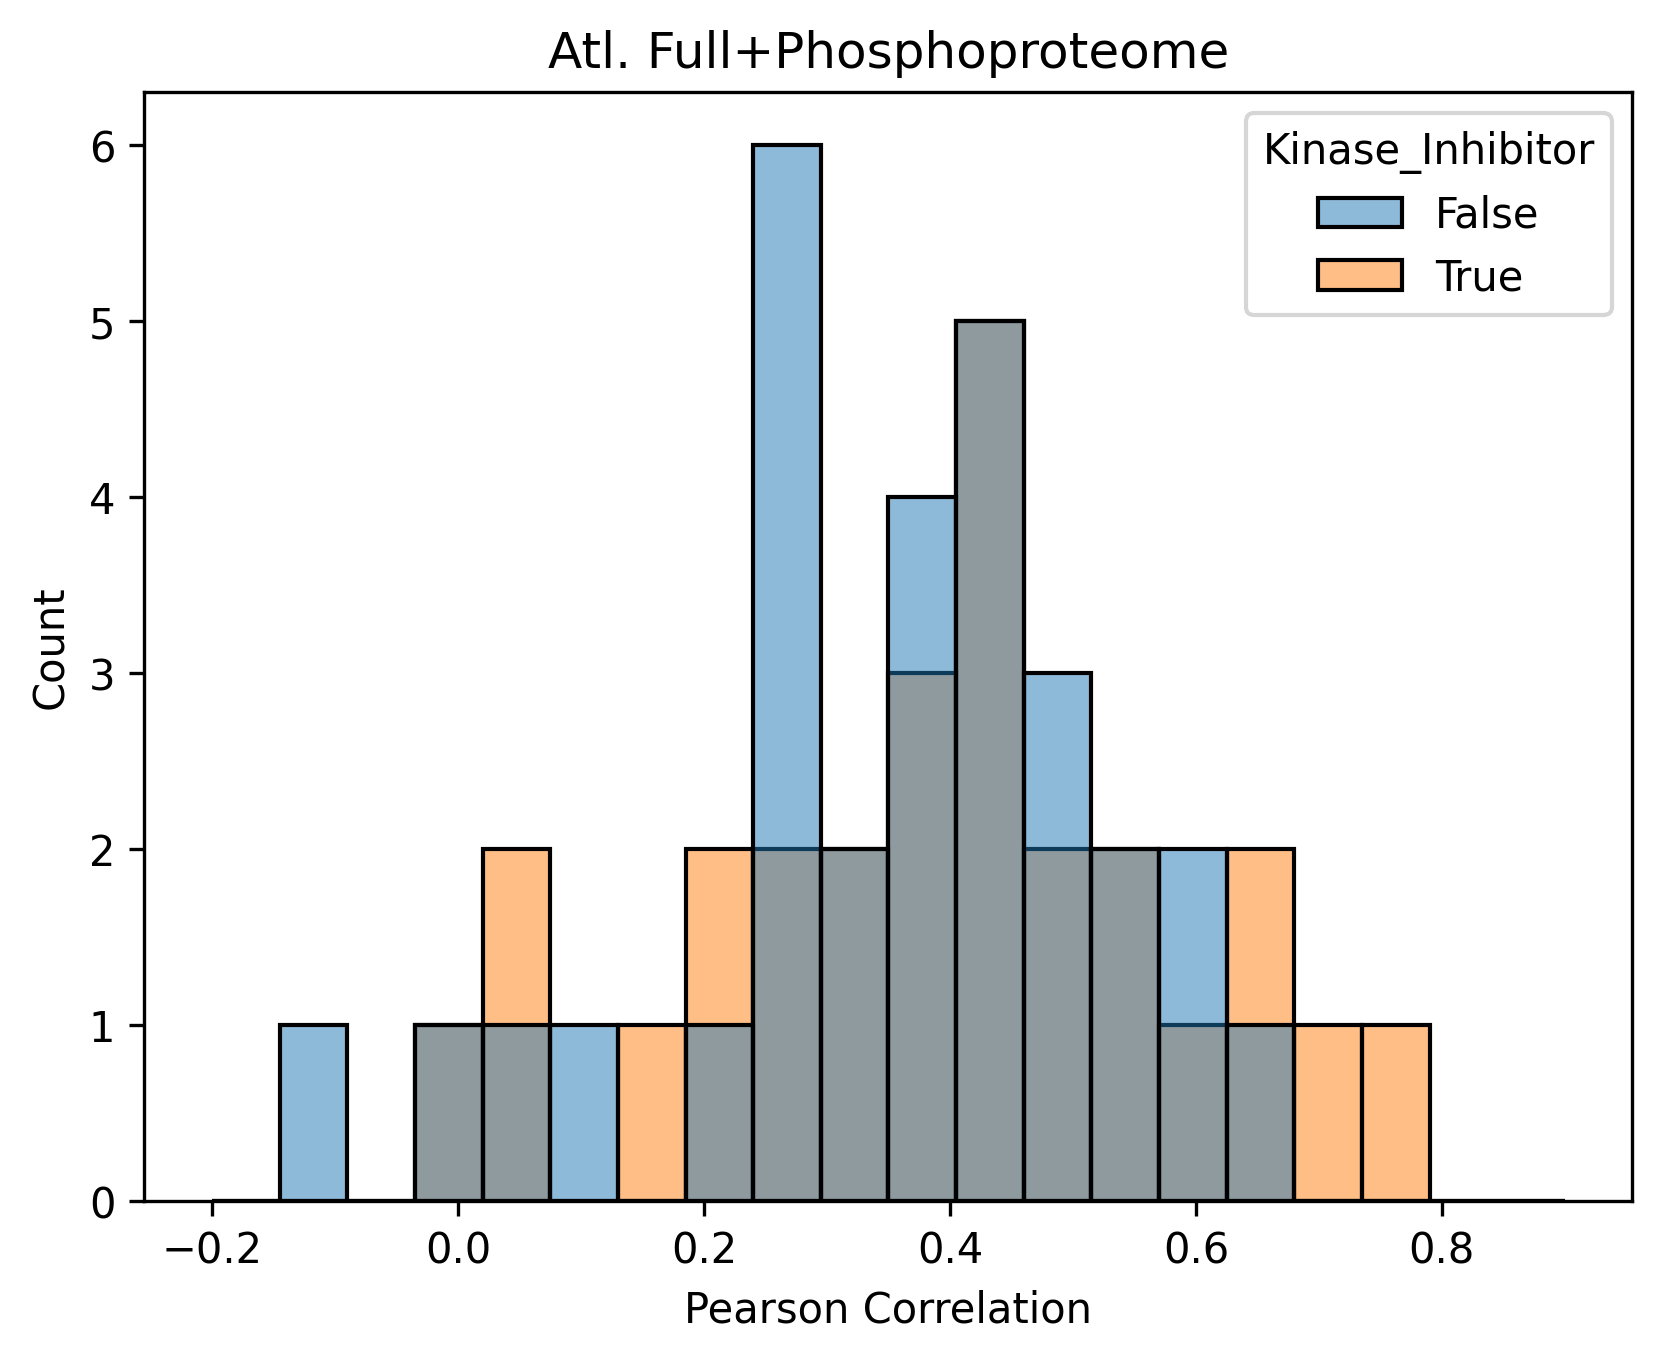

0.41938078844955784
drug_scores
GDSC2
27
30


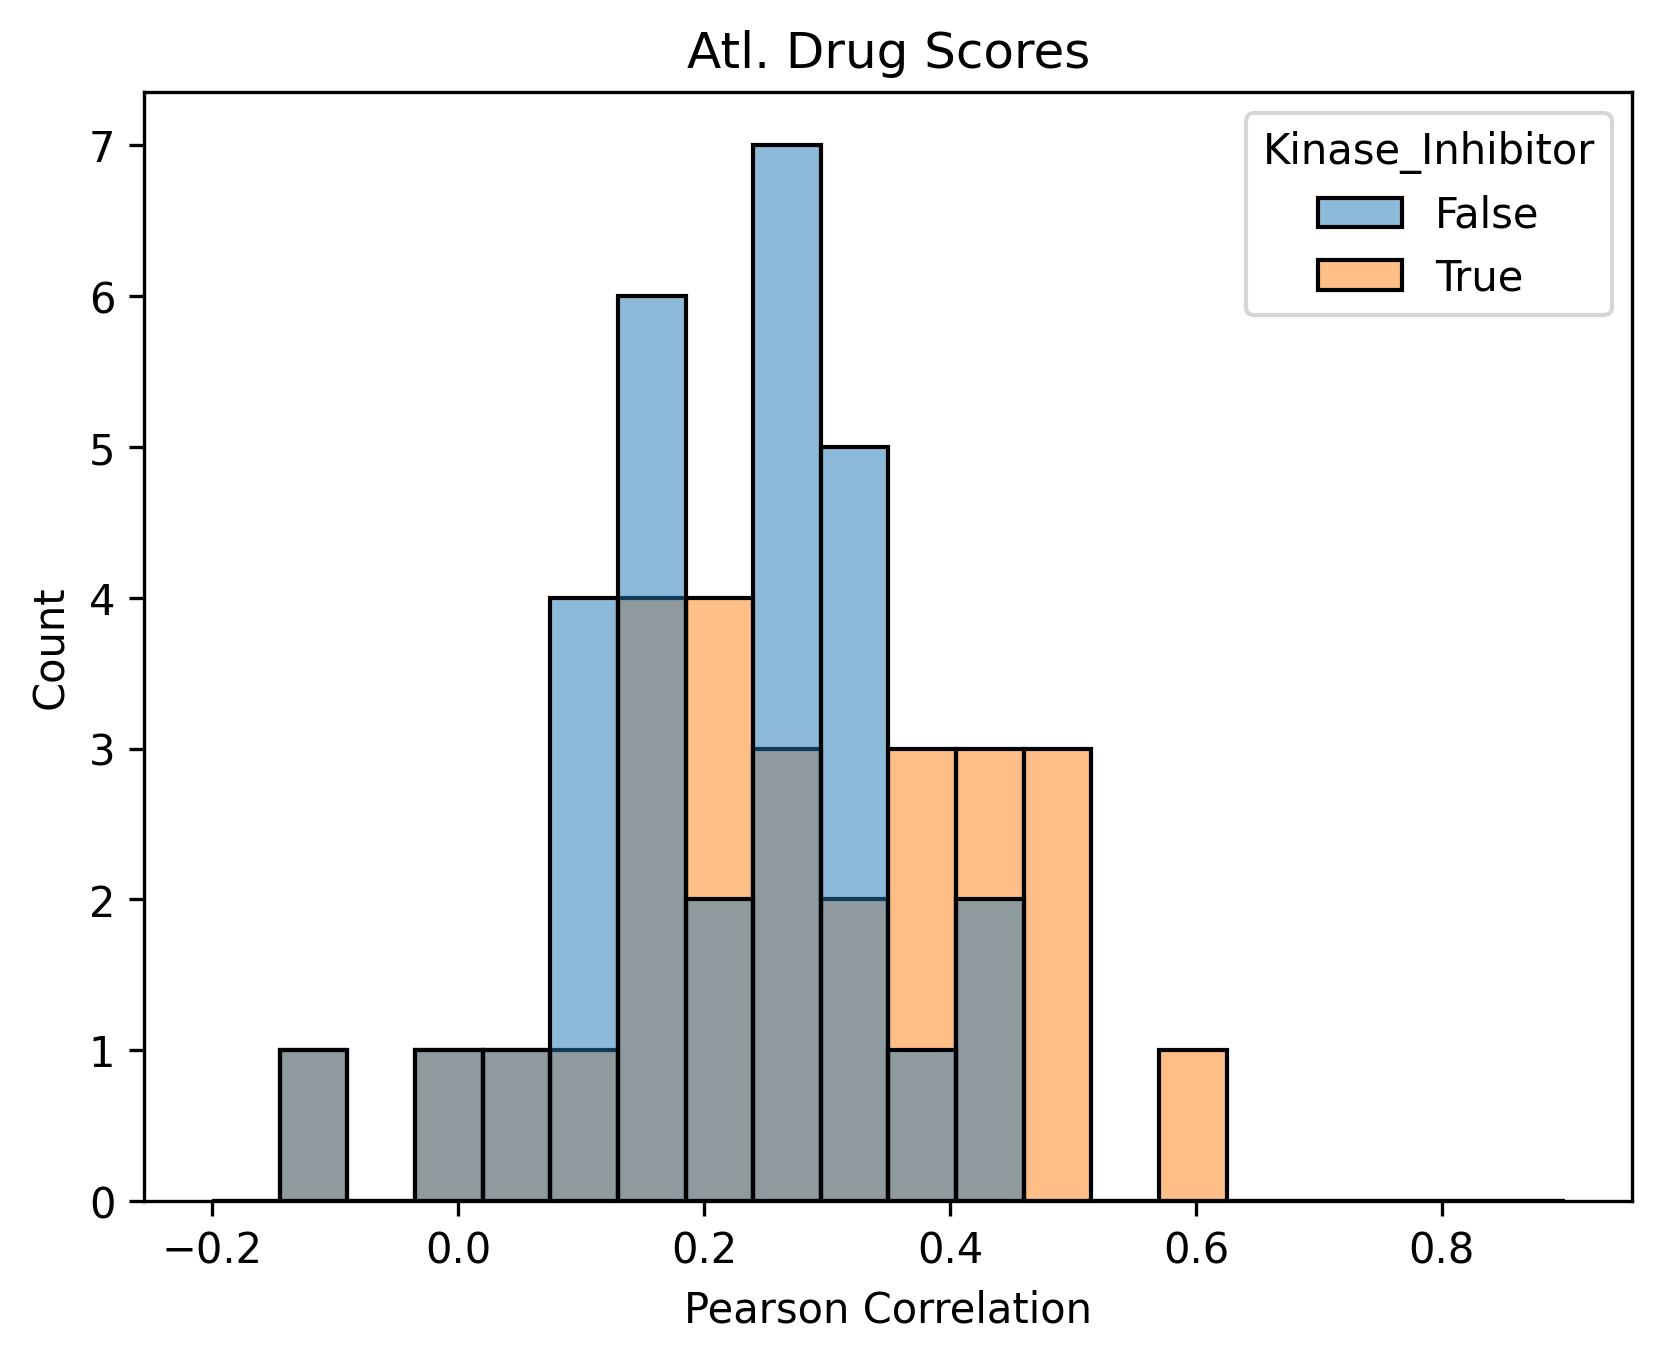

0.16521946319210526
identity
GDSC2
27
30


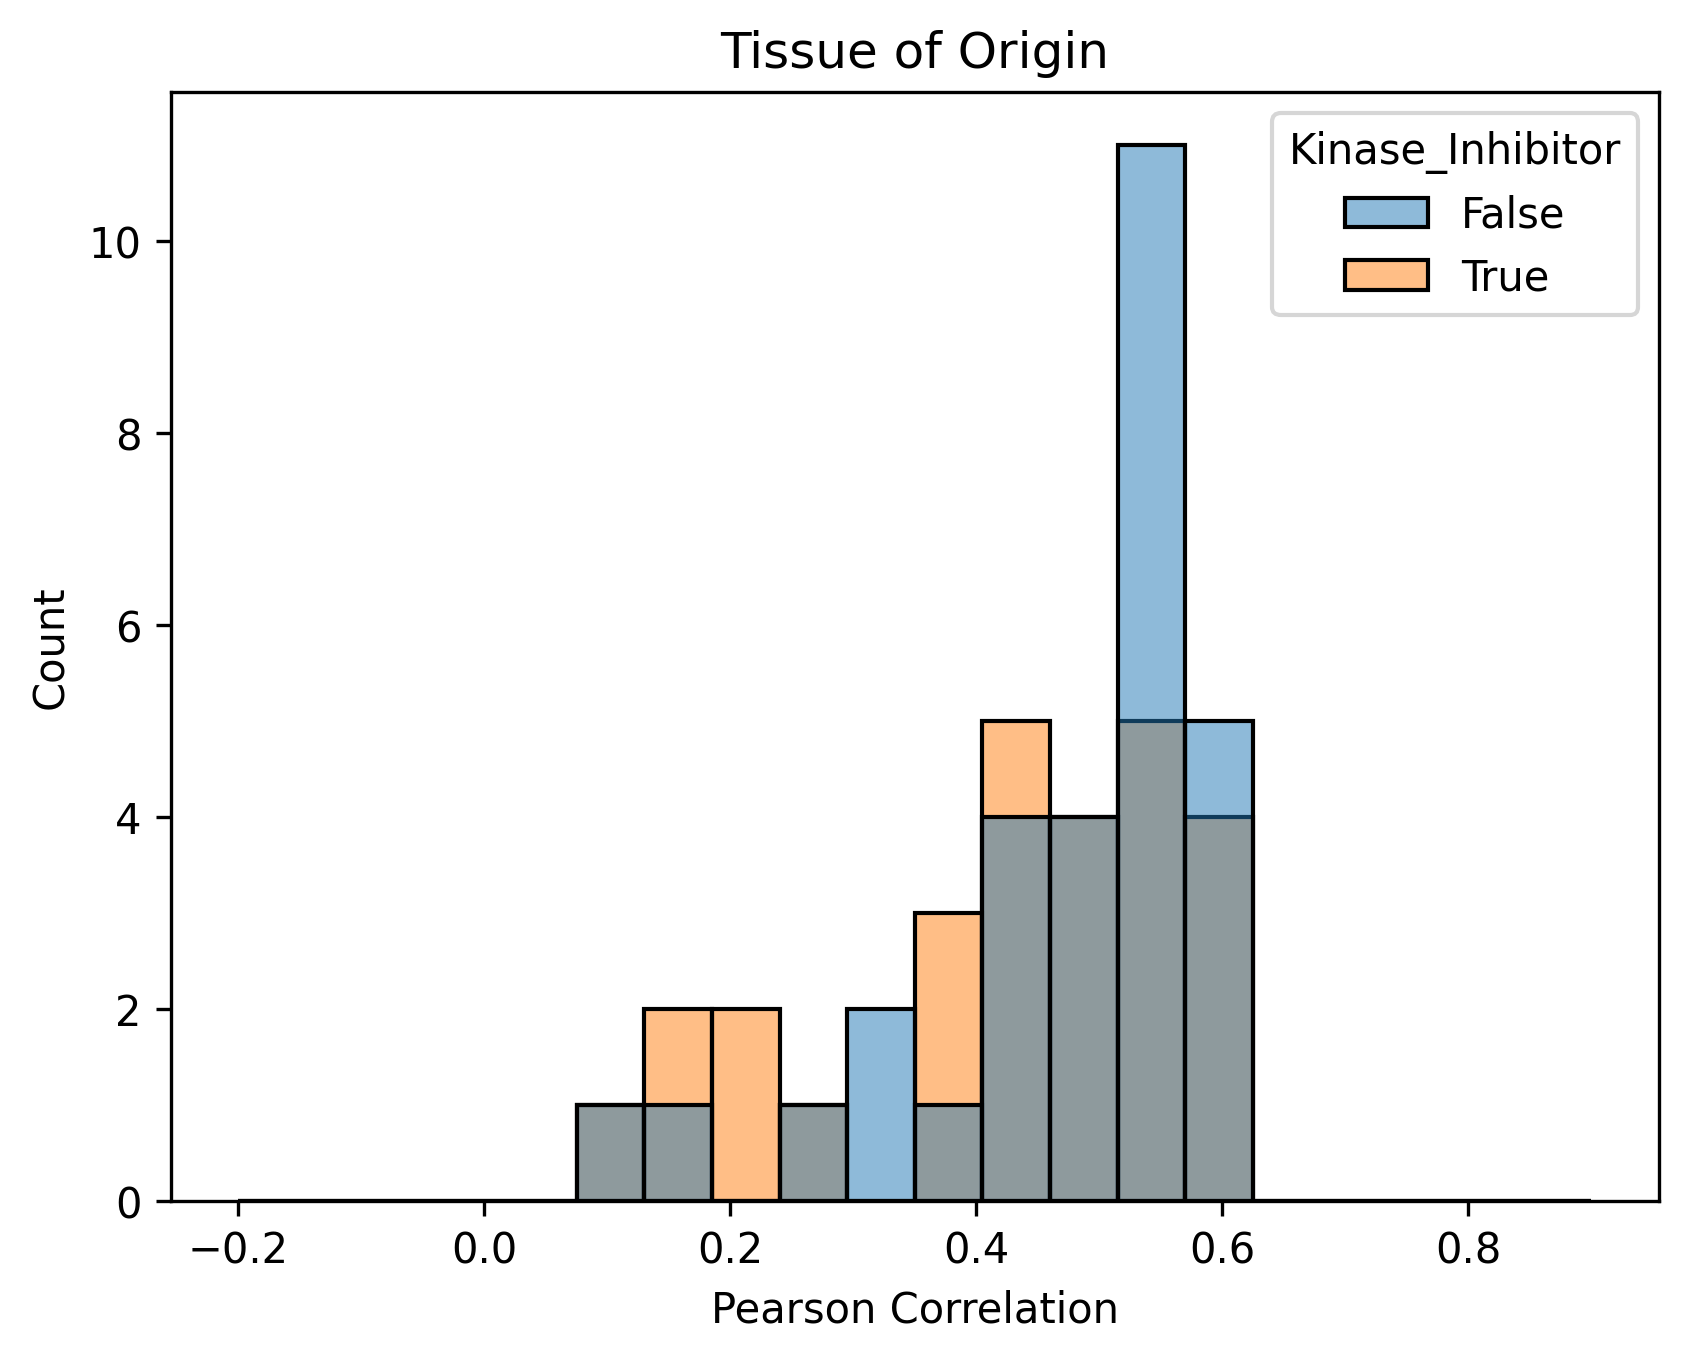

0.17842730175243962
kinase_scores
GDSC2
27
30


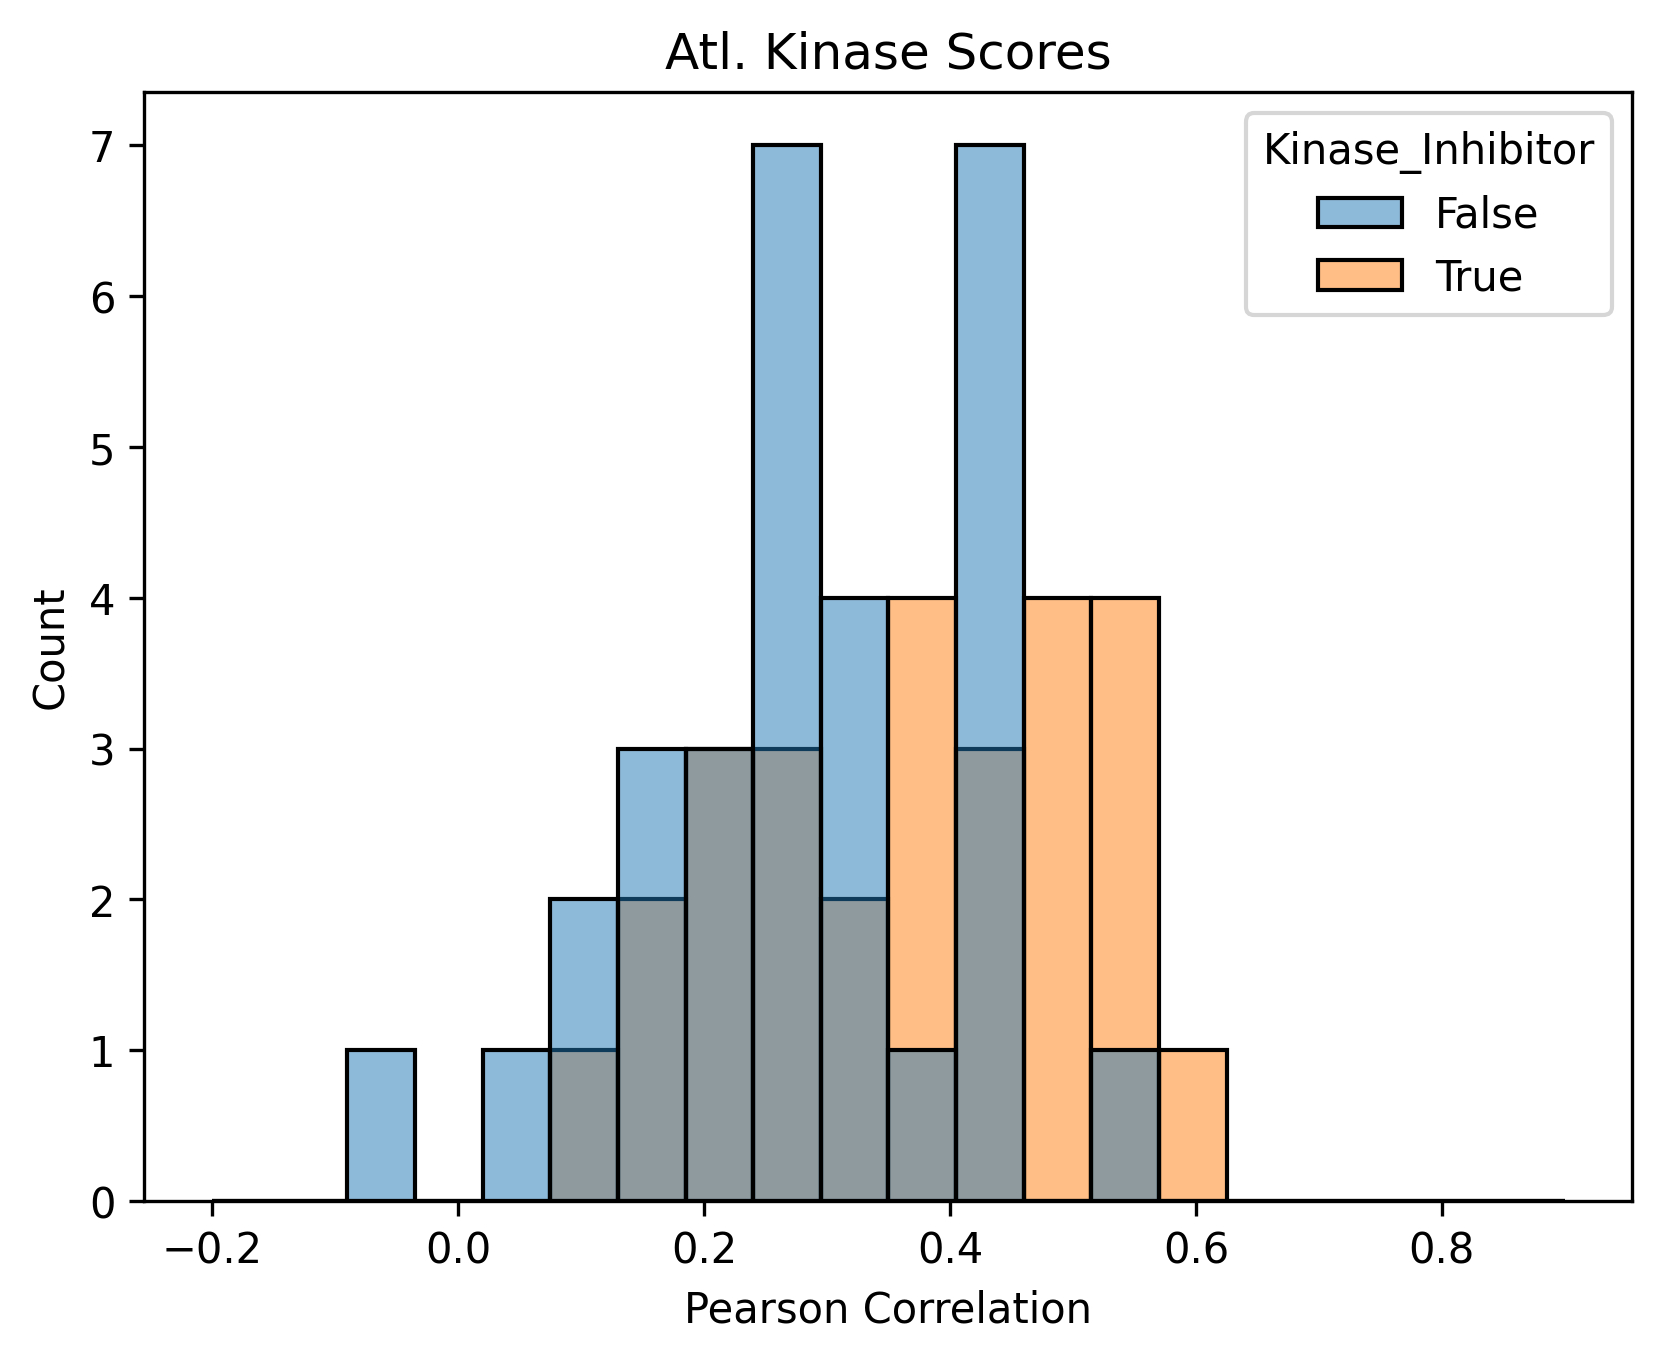

0.01625046626937997


In [61]:
D_fn = {'Gygi':'Gygi-CCLE', 'RNA':'Transcriptomics', 'atl_full_and_kinases':'Atl. Full+Kinase scores',
        'atl_only_full':'Atl. Full Proteome', 'atl_only_phos':'Atl. Phosphoproteome',
        'atlantic': 'Atl. Full+Phosphoproteome', 'drug_scores':'Atl. Drug Scores',
        'identity':'Tissue of Origin', 'kinase_scores':'Atl. Kinase Scores'}

sources = ['GDSC2']
Z0 = np.full((len(dss),len(sources)), np.NaN)
Z1 = np.full((len(dss),len(sources)), np.NaN)


for i,ds in enumerate(dss):
    for j,s in enumerate(sources):
        dfmss = dfms[(dfms['dataset']==ds)&(dfms['source']==s)].copy()
        dfmss0, dfmss1 = dfmss[dfmss['kinase_target']=='y']['pearsons'], dfmss[dfmss['kinase_target']!='y']['pearsons']

        if len(dfmss0)>10 and len(dfmss1):
            print(ds)
            print(s)
            print(len(dfmss0))
            print(len(dfmss1))
            sns.histplot(data = dfmss, x='pearsons', hue='Kinase_Inhibitor', bins=np.linspace(-0.2,0.9,21))
            ttest = scipy.stats.ttest_ind(dfmss0, dfmss1)
            plt.title(f'{D_fn[ds]}')
            plt.xlabel('Pearson Correlation')
            plt.pause(0.01)
            print(ttest.pvalue)
            Z0[i,j] = ttest.statistic
            Z1[i,j] = ttest.pvalue
Z0 = pd.DataFrame(data=Z0, index=dss, columns=sources)
Z1 = pd.DataFrame(data=Z1, index=dss, columns=sources)


Z0.index = [D_fn[a] for a in Z0.index]
Z1.index = [D_fn[a] for a in Z1.index]
Z0 = Z0.iloc[[-2,1,0,2,4,3,-1,-3]]
Z1 = Z1.iloc[[-2,1,0,2,4,3,-1,-3]]

In [35]:
dfmss

,PubChem_CID,alpha,l1_ratio,dataset,source,pearsons,spearmans,l1_ratios,RMSE,RMSE_mean_model,ind,n_ccls,kn,drug_repr,RMSE_ratio,dr,kinase_target,Kinase_Inhibitor
13657,10127622,0.30,0.10,kinase_scores,GDSC2,0.503419,0.509540,0.906403,0.136560,0.154568,49.5,81.0,1.000000e+09,selumetinib,0.883494,selumetinib,y,True
13658,10384072,0.03,0.99,kinase_scores,GDSC2,0.309798,0.293447,0.972967,0.095175,0.097568,49.5,81.0,1.000000e+09,Wee1 Inhibitor,0.975475,wee1 inhibitor,y,True
13659,11152667,0.03,0.03,kinase_scores,GDSC2,0.442964,0.412519,1.041554,0.088270,0.093511,49.5,82.0,1.000000e+09,AZD7762,0.943961,azd7762,y,True
13660,11228183,1.00,0.01,kinase_scores,GDSC2,0.442485,0.414014,0.887567,0.092431,0.102662,49.5,81.0,1.000000e+09,ABT737,0.900347,abt737,x,False
13661,11364421,1.00,0.01,kinase_scores,GDSC2,0.353918,0.318960,0.954534,0.157864,0.167419,49.5,76.0,1.000000e+09,BI-2536,0.942929,bi2536,y,True
13663,11626560,0.01,0.03,kinase_scores,GDSC2,0.367067,0.293256,1.207703,0.080093,0.075659,49.5,82.0,1.000000e+09,crizotinib,1.058605,crizotinib,y,True
13664,11634725,3.00,0.01,kinase_scores,GDSC2,0.548591,0.523719,0.913742,0.123163,0.134835,49.5,81.0,1.000000e+09,VX-11e,0.913432,vx11e,y,True
13665,11707110,1.00,0.01,kinase_scores,GDSC2,0.594851,0.600320,0.754091,0.162169,0.198976,49.5,82.0,1.000000e+09,trametinib,0.815022,trametinib,y,True
13666,11719003,0.03,0.90,kinase_scores,GDSC2,0.551045,0.539174,0.873185,0.086337,0.097810,49.5,81.0,1.000000e+09,ulixertinib,0.882701,ulixertinib,y,True
13667,118693659,1.00,0.01,kinase_scores,GDSC2,0.130886,0.091639,1.003681,0.114383,0.113487,49.5,76.0,1.000000e+09,AZD5153,1.007892,azd5153,x,False


In [27]:
plt.rcParams['figure.dpi'] = 300

<Axes: >

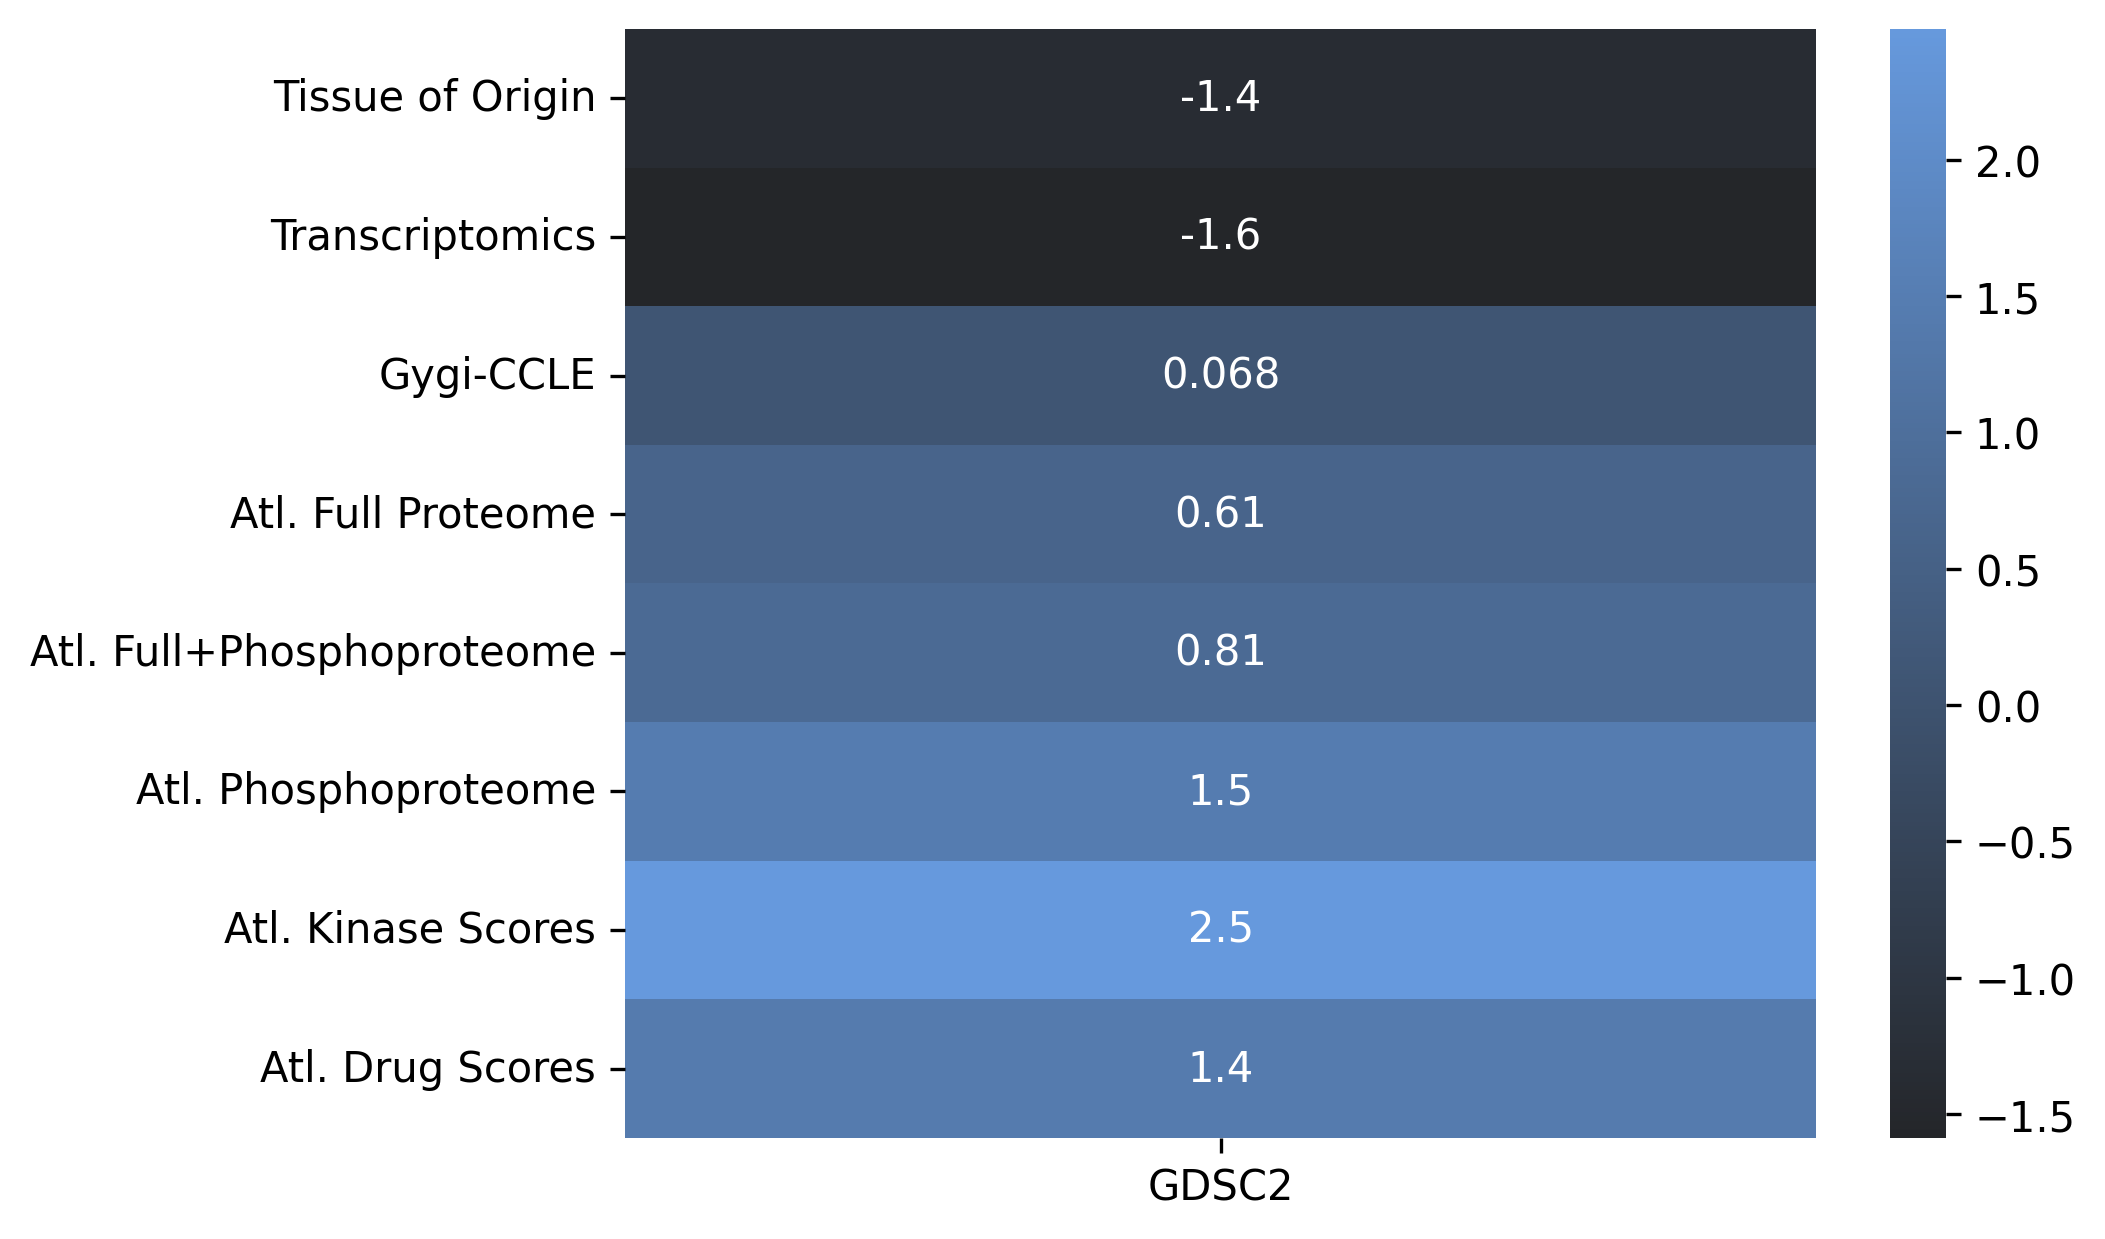

In [28]:
cmap = sns.dark_palette("#69d", reverse=False, as_cmap=True)
sns.heatmap(data=Z0, annot=True, cmap=cmap)

<Axes: >

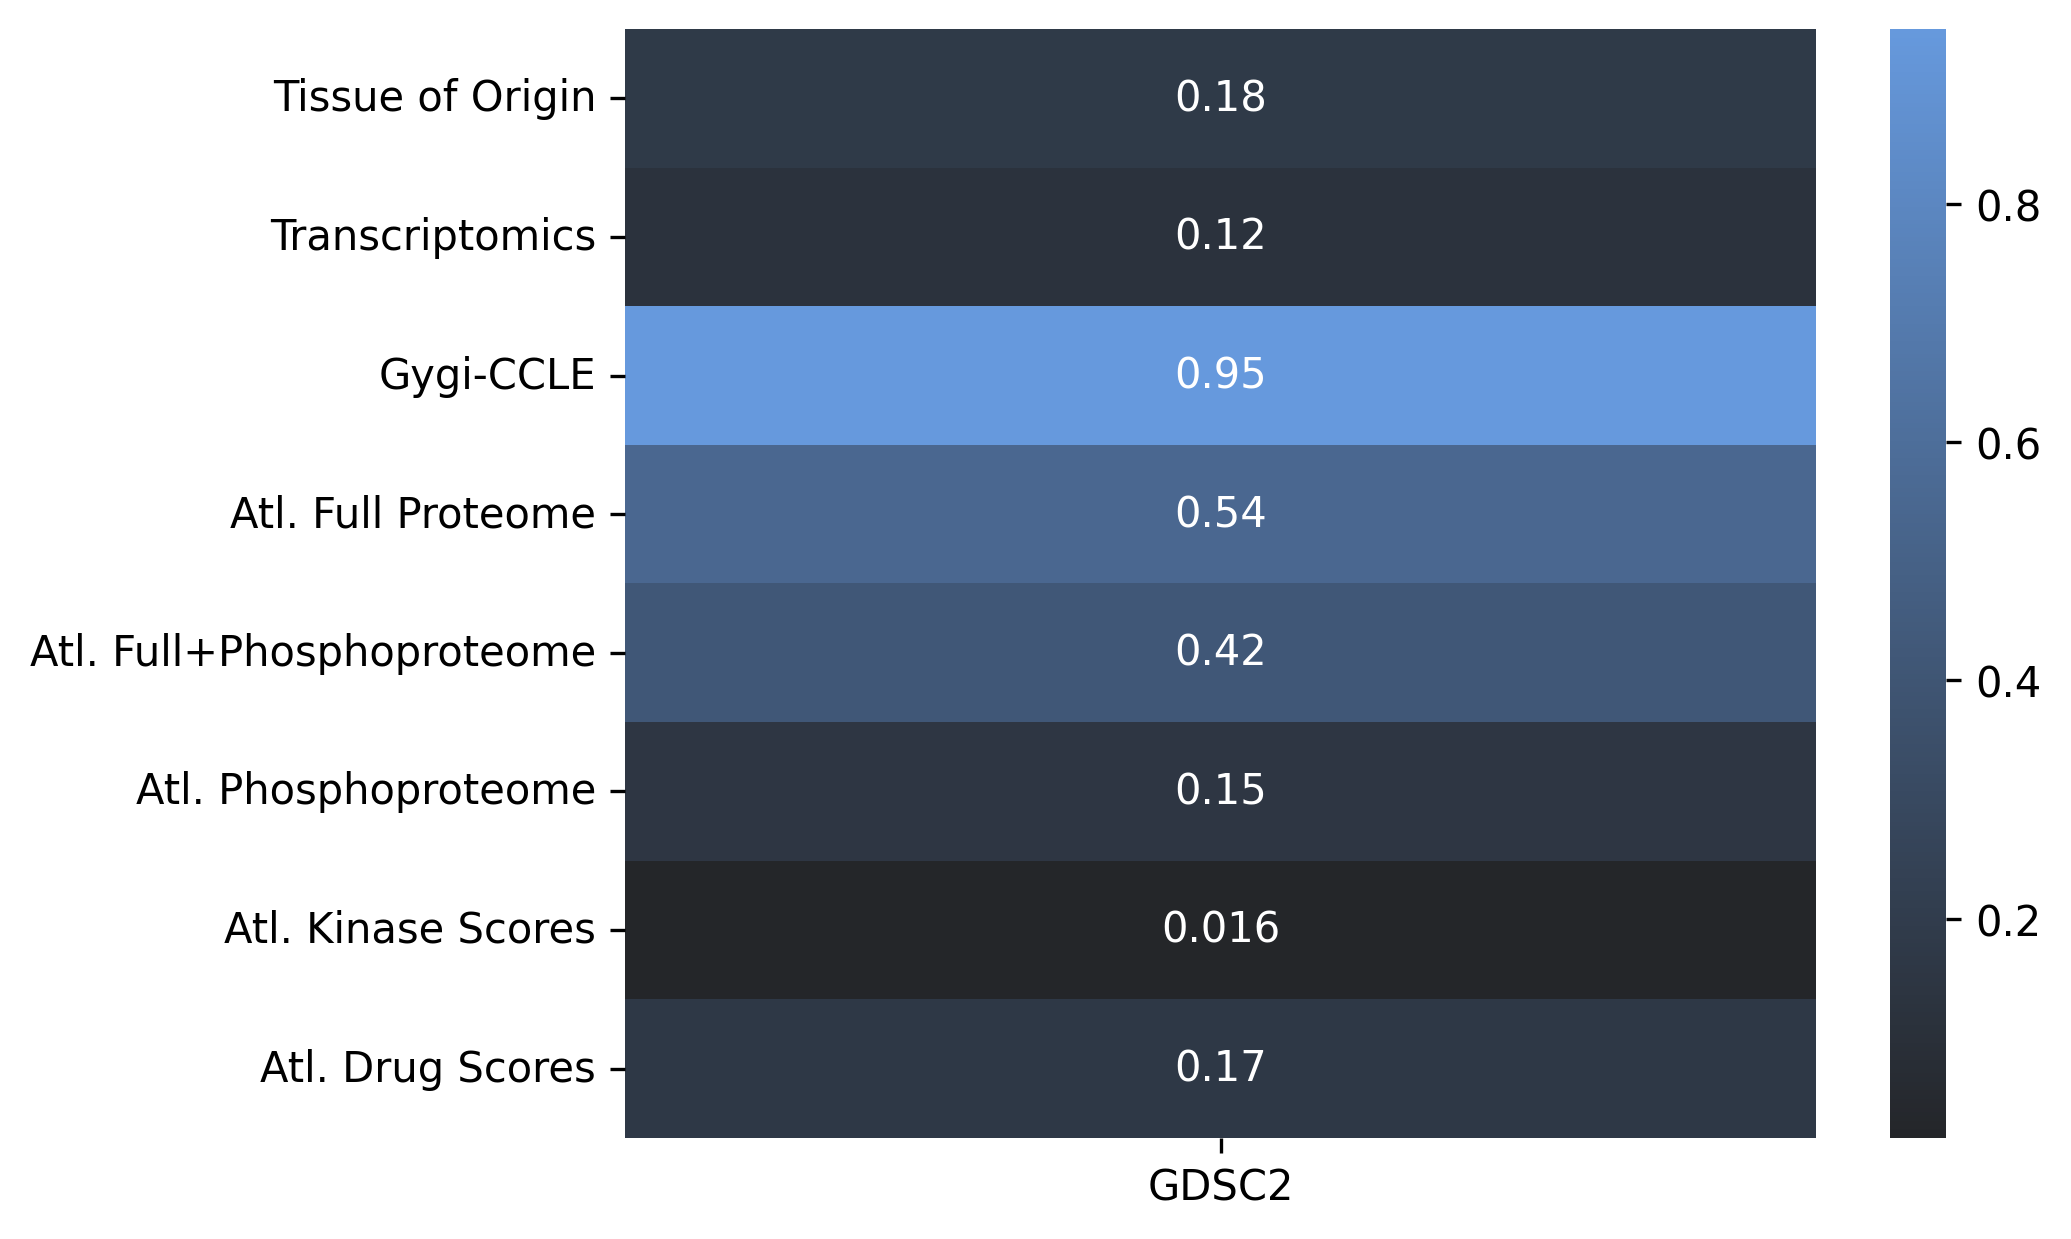

In [29]:
cmap = sns.dark_palette("#69d", reverse=False, as_cmap=True)
sns.heatmap(data=Z1, annot=True, cmap=cmap)